# Loading and Verification

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
df = pd.read_csv('sales_data.csv')

In [2]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16393 entries, 0 to 16392
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     16393 non-null  object
 1   rating                    16334 non-null  object
 2   number_of_reviews         16334 non-null  object
 3   bought_in_last_month      14963 non-null  object
 4   current/discounted_price  11895 non-null  object
 5   price_on_variant          16393 non-null  object
 6   listed_price              16393 non-null  object
 7   is_best_seller            16393 non-null  object
 8   is_sponsored              16393 non-null  object
 9   is_couponed               16393 non-null  object
 10  buy_box_availability      10894 non-null  object
 11  delivery_details          11968 non-null  object
 12  sustainability_badges     1256 non-null   object
 13  image_url                 16393 non-null  object
 14  product_url           

,title,rating,number_of_reviews,bought_in_last_month,current/discounted_price,price_on_variant,listed_price,is_best_seller,is_sponsored,is_couponed,buy_box_availability,delivery_details,sustainability_badges,image_url,product_url,collected_at
count,16393,16334,16334,14963,11895,16393,16393,16393,16393,16393,10894,11968,1256,16393,15496,16392
unique,8561,31,4313,52,2499,3391,885,4,2,34,1,206,16,7818,15496,590
top,"Duracell Coppertop 9V Battery, 6 Count (Pack o...",4.4 out of 5 stars,8,100+ bought in past month,29.99,basic variant price: nan,No Discount,No Badge,Organic,No Coupon,Add to cart,"Delivery Mon, Sep 1",Small Business,https://m.media-amazon.com/images/I/51Xr76m2WL...,/Dell-Inspiron-3511-Non-Touch-Laptop/dp/B09GYN...,2025-08-25 10:47:14
freq,301,2744,251,2558,370,7795,11881,15917,13594,15678,10894,5947,490,487,1,33


In [3]:
df.isnull().sum()

,0
title,0
rating,59
number_of_reviews,59
bought_in_last_month,1430
current/discounted_price,4498
price_on_variant,0
listed_price,0
is_best_seller,0
is_sponsored,0
is_couponed,0


# Cleaning

In [6]:
def cleaned_up_code(rows_of_data):
  fill_zero_cols = ['number_of_reviews', 'bought_in_last_month']
  fill_unknown_cols =  ['product_url', 'delivery_details', 'buy_box_availability']
  fill_blank_cols = ['sustainability_badges']
  special_numeric_cols = ['number_of_reviews', 'listed_price', 'price_on_variant', 'current/discounted_price']
  raw_cols = ['bought_in_last_month', 'price_on_variant', 'listed_price', 'rating']
  for col in fill_zero_cols:
    rows_of_data[col] = rows_of_data[col].fillna(0)
  for col in fill_unknown_cols:
    rows_of_data[col] = rows_of_data[col].fillna('Unknown')
  for col in fill_blank_cols:
    rows_of_data[col] = rows_of_data[col].fillna('')
  rows_of_data['rating_numeric'] = pd.to_numeric(
  rows_of_data['rating'].str.extract(r'(\d+\.\d+)')[0], errors='coerce'
  )
  for col in special_numeric_cols:
    rows_of_data[col] = pd.to_numeric(rows_of_data[col], errors='coerce').astype(float)

  def extract_numeric_column(col, remove_text=None, special_cases=None):
    def converter(x):
      if isinstance(x, str):
        val = x.lower()
        if special_cases:
          for case in special_cases:
            if case.lower() in val:
              return np.nan
        if remove_text:
          for txt in remove_text:
            val = val.replace(txt, '')
        match = re.search(r'(\d+\.?\d*)', val)
        if match:
          number = float(match.group(1))
          if 'k' in val: number *= 1000
          return number
      elif isinstance(x, (int, float)):
        return x
      return np.nan
    return col.apply(converter)

  rows_of_data['bought_in_last_month_clean'] = extract_numeric_column(rows_of_data['bought_in_last_month'], remove_text=['+'])
  rows_of_data['price_on_variant_clean'] = extract_numeric_column(rows_of_data['price_on_variant'], remove_text=['$'])
  rows_of_data['listed_price_clean'] = extract_numeric_column(rows_of_data['listed_price'], remove_text=['$'], special_cases=['No Discount'])

  rows_of_data.drop(columns=[c for c in raw_cols if c in rows_of_data.columns], inplace=True)

  string_cols = ['buy_box_availability', 'delivery_details', 'sustainability_badges', 'product_url']
  for col in string_cols:
    rows_of_data[col] = rows_of_data[col].fillna('').astype(str)

  grouped_df = rows_of_data.groupby('title').agg({
    'rating_numeric': 'mean', #aggergation
    'number_of_reviews': 'sum', #aggergation
    'bought_in_last_month_clean': 'sum', #aggergation
    'listed_price_clean': lambda x: x.mean() if len(x.dropna())> 0 else np.nan, #aggergation
    'price_on_variant_clean': 'mean', #aggergation
    'current/discounted_price': 'mean', #aggergation
    'buy_box_availability': 'first', #categoral columns, where first means one representative value per product
    'delivery_details': 'first', #categoral columns, where first means one representative value per product
    'sustainability_badges': 'first' #categoral columns, where first means one representative value per product
}).reset_index()

  return grouped_df

In [7]:
grouped_df = cleaned_up_code(df)

In [8]:
grouped_df.isnull().sum()

,0
title,0
rating_numeric,46
number_of_reviews,0
bought_in_last_month_clean,0
listed_price_clean,8561
price_on_variant_clean,8561
current/discounted_price,2934
buy_box_availability,0
delivery_details,0
sustainability_badges,0


### Legacy

In [5]:
# def extract_numeric_column(col, remove_text=None, special_cases=None):
#   def converter(x):
#     if isinstance(x, str):
#       val = x.lower()
#       if special_cases:
#         for case in special_cases:
#           if case.lower() in val:
#             return np.nan
#       if remove_text:
#         for txt in remove_text:
#           val = val.replace(txt, '')
#       val = val.replace('k', '000')
#       match = re.search(r'(\d+\.?\d*)', val)
#       if match:
#         return float(match.group(1))
#     elif isinstance(x, (int, float)):
#       return x
#     return np.nan
#   return col.apply(converter)

In [6]:
# rows_of_data['bought_in_last_month_clean'] = extract_numeric_column(rows_of_data['bought_in_last_month'], remove_text=['+'])
# rows_of_data['price_on_variant_clean'] = extract_numeric_column(rows_of_data['price_on_variant'], remove_text=['$'])
# rows_of_data['listed_price_clean'] = extract_numeric_column(rows_of_data['listed_price'], remove_text=['$'], special_cases=['No Discount'])

In [8]:
# df[['number_of_reviews', 'bought_in_last_month', ]] = df[['number_of_reviews', 'bought_in_last_month', ]].fillna(0)
# cleaned with 0's because the values in place could easily be satisfied with 0

In [9]:
# df[['product_url', 'delivery_details', 'buy_box_availability']] = df[['product_url', 'delivery_details', 'buy_box_availability']].fillna('')
# df['sustainability_badges'] = df['sustainability_badges'].fillna('Unknown')
#Unknown was used because these categories had easy interpretation of what should be

In [10]:
# df['rating_numeric'] = df['rating'].str.extract(r'(\d+\.\d+)').astype(float)
# df['rating_numeric'] = pd.to_numeric(df['rating_numeric'])
# #rating needed to be converted to numeric to make graphing easier in the future.

In [11]:
# df['bought_in_last_month_clean'] = df['bought_in_last_month'].str.replace('+', '', regex=False)
# def convert_to_number(x):
#     if isinstance(x, str):
#         x = x.lower().replace('k', '000')
#         match = re.search(r'(\d+\.?\d*)', x)
#         if match:
#             return float(match.group())
#     return x

# df['bought_in_last_month_clean'] = df['bought_in_last_month'].apply(convert_to_number)
# #made the string into numeric values, easier to read and compute

In [12]:
# def extract_price_variant(x):
#   if isinstance(x, str):
#     match = re.search(r'\$?(\d+\.?\d*)', x)
#     if match:
#       return float(match.group(1))
#   return np.nan
# df['price_on_variant_clean'] = df['price_on_variant'].apply(extract_price_variant)
# #converts all of my non numeric values into numeric values that can be used

In [13]:
# def clean_listed_price(x):
#   if isinstance(x, str):
#     if 'no discount' in x.lower():
#       return np.nan
#     match = re.search(r'\$?(\d+\.?\d*)', x)
#     if match:
#       return float(match.group(1))
#   elif isinstance(x, (int, float)):
#     return x
#   return np.nan
# df['listed_price_clean'] = df['listed_price'].apply(clean_listed_price)
# #Listed price needed to be changed to numeric blank values because No Discount is confusing

In [7]:
# df.drop(columns=[
#     'bought_in_last_month',
#     'price_on_variant',
#     'listed_price',
#     'rating'
# ], inplace=True)
# #dropped irrelavant columns

In [8]:
# string_cols = ['buy_box_availability', 'delivery_details', 'sustainability_badges', 'product_url']
# for col in string_cols:
#     df[col] = df[col].fillna('').astype(str)
# #making it easier to group these columns if they are strings

In [7]:
# for col in ['number_of_reviews', 'bought_in_last_month_clean',
#             'listed_price_clean', 'price_on_variant_clean', 'current/discounted_price']:
#     print(col, df[col].apply(type).value_counts())
# #verifying values

number_of_reviews number_of_reviews
<class 'str'>      16334
<class 'float'>       59
Name: count, dtype: int64


KeyError: 'bought_in_last_month_clean'

In [17]:
# numeric_cols = ['number_of_reviews', 'bought_in_last_month_clean',
#             'listed_price_clean', 'price_on_variant_clean', 'current/discounted_price']
# for col in numeric_cols:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# Grouping/Aggregation

In [10]:
# grouped_df = df.groupby('title').agg({
#     'rating_numeric': 'mean', #aggergation
#     'number_of_reviews': 'sum', #aggergation
#     'bought_in_last_month_clean': 'sum', #aggergation
#     'listed_price_clean': 'mean', #aggergation
#     'price_on_variant_clean': 'mean', #aggergation
#     'current/discounted_price': 'mean', #aggergation
#     'buy_box_availability': 'first', #categoral columns, where first means one representative value per product
#     'delivery_details': 'first', #categoral columns, where first means one representative value per product
#     'sustainability_badges': 'first' #categoral columns, where first means one representative value per product
# }).reset_index()

#Derived Metrics

In [9]:
def derived_metrics(grouped_df):
  # Discount metrics
  grouped_df['discount_amount'] = grouped_df['listed_price_clean'] - grouped_df['price_on_variant_clean']
  grouped_df['discount_percentage'] = (grouped_df['discount_amount'] / grouped_df['listed_price_clean']) * 100
  # Purchase Efficiency
  grouped_df['purchase_efficiency'] = grouped_df['bought_in_last_month_clean'] / grouped_df['number_of_reviews'].replace(0, np.nan)
  # Price Category
  median_price = grouped_df['listed_price_clean'].median()
  grouped_df['is_high_value_product'] = grouped_df['listed_price_clean'] > median_price
  grouped_df['price_bracket'] = pd.cut(grouped_df['listed_price_clean'], bins=[0, 50, 150, 500, 1000], labels=["Low", "Medium", "High", "Very High"])

  # popularity metrics
  median_purchases = grouped_df['bought_in_last_month_clean'].median()
  grouped_df['is_popular'] = grouped_df['bought_in_last_month_clean'] > median_purchases

  # discount effectiveness
  grouped_df['discount_effectiveness'] = grouped_df['discount_amount'] / grouped_df['listed_price_clean'].replace(0, np.nan)

  return grouped_df

In [10]:
grouped_df = derived_metrics(grouped_df)

### Legacy

In [11]:
# # discount metrics
# df['discount_amount'] = df['listed_price_clean'] - df['price_on_variant_clean']
# df['discount_percentage'] = (df['discount_amount'] / df['listed_price_clean']) * 100

In [12]:
# # Purchase Efficiency
# df['purchase_efficiency'] = df['bought_in_last_month_clean'] / df['number_of_reviews']

In [13]:
# #Price Category
# median_price = df['listed_price_clean'].median()
# df['is_high_value_product'] = df['listed_price_clean'] > median_price
# df['price_bracket'] = pd.cut(df['listed_price_clean'], bins=[0, 50, 150, 500, 1000], labels=["Low", "Medium", "High", "Very High"])

In [14]:
# #popularity metrics
# median_purchases = df['bought_in_last_month_clean'].median()
# df['is_popular'] = df['bought_in_last_month_clean'] > median_purchases

In [15]:
# #discount effectiveness
# df['discount_effectiveness'] = df['discount_amount'] / df['listed_price_clean']

# EDA / Trend Analysis

## Verification of Grouped Aggregation

In [16]:
df.describe()

,number_of_reviews,current/discounted_price,rating_numeric,bought_in_last_month_clean,price_on_variant_clean,listed_price_clean
count,9243.000000,11633.000000,16334.000000,14330.000000,0.0,0.0
mean,246.342313,139.071951,4.427232,1324.359499,NaN,NaN
std,256.870357,187.387791,0.309878,5046.621040,NaN,NaN
min,0.000000,2.490000,1.000000,0.000000,NaN,NaN
25%,45.000000,25.490000,4.300000,100.000000,NaN,NaN
50%,171.000000,68.990000,4.500000,200.000000,NaN,NaN
75%,345.000000,164.990000,4.700000,500.000000,NaN,NaN
max,999.000000,999.990000,5.000000,100000.000000,NaN,NaN


In [17]:
df.sort_values('rating_numeric', ascending=False).head(10)

# Products with most reviews
df.sort_values('number_of_reviews', ascending=False).head(10)

# Products with most bought in last month
df.sort_values('bought_in_last_month_clean', ascending=False).head(10)

,title,number_of_reviews,current/discounted_price,is_best_seller,is_sponsored,is_couponed,buy_box_availability,delivery_details,sustainability_badges,image_url,product_url,collected_at,rating_numeric,bought_in_last_month_clean,price_on_variant_clean,listed_price_clean
1901,"Energizer AA Batteries Alkaline Power, 32 Coun...",NaN,16.95,Amazon's,Sponsored,No Coupon,Add to cart,"Delivery Mon, Sep 1",,https://m.media-amazon.com/images/I/91-R5huHLn...,Unknown,2025-08-21 11:29:08,4.8,100000.0,NaN,NaN
853,"Energizer AA Batteries Alkaline Power, 32 Coun...",NaN,16.95,No Badge,Sponsored,No Coupon,Add to cart,"Delivery Mon, Sep 1",,https://m.media-amazon.com/images/I/91-R5huHLn...,Unknown,2025-08-21 11:21:25,4.8,100000.0,NaN,NaN
2503,"Energizer AA Batteries Alkaline Power, 32 Coun...",NaN,16.95,No Badge,Sponsored,No Coupon,Add to cart,"Delivery Mon, Sep 1",,https://m.media-amazon.com/images/I/91-R5huHLn...,Unknown,2025-08-21 11:33:27,4.8,100000.0,NaN,NaN
2305,"Energizer AA Batteries Alkaline Power, 32 Coun...",NaN,16.95,No Badge,Sponsored,No Coupon,Add to cart,"Delivery Mon, Sep 1",,https://m.media-amazon.com/images/I/91-R5huHLn...,Unknown,2025-08-21 11:32:00,4.8,100000.0,NaN,NaN
4679,"Energizer AA Batteries Alkaline Power, 32 Coun...",NaN,16.95,Amazon's,Sponsored,No Coupon,Add to cart,"Delivery Mon, Sep 1",,https://m.media-amazon.com/images/I/91-R5huHLn...,Unknown,2025-08-21 11:49:00,4.8,100000.0,NaN,NaN
17,Amazon Basics AAA Alkaline High-Performance Ba...,NaN,14.49,Best Seller,Organic,No Coupon,Add to cart,"Delivery Fri, Aug 29",Safer chemicals +1 more,https://m.media-amazon.com/images/I/81Apg8B6+0...,/Amazon-Basics-AAA-High-Performance-36/dp/B00L...,2025-08-21 11:14:29,4.7,100000.0,NaN,NaN
18,Amazon Basics Clear Thermal Laminating Plastic...,NaN,16.98,Best Seller,Organic,No Coupon,Add to cart,"Delivery Fri, Aug 29",,https://m.media-amazon.com/images/I/61cefAp7H5...,/AmazonBasics-Thermal-Laminating-Plastic-Lamin...,2025-08-21 11:14:29,4.8,100000.0,NaN,NaN
20,"Energizer AA Batteries Alkaline Power, 32 Coun...",NaN,16.95,No Badge,Organic,No Coupon,Add to cart,"Delivery Fri, Aug 29",,https://m.media-amazon.com/images/I/91-R5huHLn...,Unknown,2025-08-21 11:14:29,4.8,100000.0,NaN,NaN
22,"Amazon Basics Wood-Cased #2 Pencils, Pre-sharp...",NaN,9.89,No Badge,Organic,No Coupon,Add to cart,"Delivery Fri, Aug 29",,https://m.media-amazon.com/images/I/81qxJ-PgGL...,/AmazonBasics-Pre-sharpened-Wood-Cased-Pencils...,2025-08-21 11:14:29,4.8,100000.0,NaN,NaN
5,Texas Instruments TI-84 Plus CE Color Graphing...,NaN,NaN,Best Seller,Organic,No Coupon,Unknown,Unknown,,https://m.media-amazon.com/images/I/71AyPChhFd...,/Texas-Instruments-TI-84-Graphing-Calculator/d...,2025-08-21 11:14:29,4.6,100000.0,NaN,NaN


In [13]:
print(grouped_df[['price_bracket', 'discount_effectiveness']].head())
print(grouped_df['price_bracket'].value_counts())


  price_bracket  discount_effectiveness
0           NaN                     NaN
1           NaN                     NaN
2           NaN                     NaN
3           NaN                     NaN
4           NaN                     NaN
price_bracket
Low          0
Medium       0
High         0
Very High    0
Name: count, dtype: int64


## General EDA Based on Original Columns

In [12]:
def eda_df(grouped_df):
#Summary Metrics
  summary_metrics = grouped_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
  summary_metrics.rename(columns={'50%':'median'}, inplace=True)
  print("\n---Overall Summary Metrics ---\n")
  display(summary_metrics)

#Segment Analysis
#Price Bracket Analysis
  print("\n--- Segment Analysis by Price Bracket ---\n")
  segment_table = grouped_df.groupby('price_bracket', observed=False).agg({
    'listed_price_clean': ['mean', 'median'],
    'price_on_variant_clean': ['mean', 'median'],
    'discount_amount': ['mean', 'median'],
    'bought_in_last_month_clean': ['sum', 'mean'],
    'purchase_efficiency': 'mean',
    'discount_effectiveness': 'mean'
  })
  display(segment_table)

#Popularity
  print("\n--- Segment Analysis by Popularity ---\n")
  popularity_table = grouped_df.groupby('is_popular').agg({
    'bought_in_last_month_clean': ['sum', 'mean'],
    'purchase_efficiency': 'mean',
    'discount_effectiveness': 'mean'
  })
  display(popularity_table)

#Key Visuals for Metrics
  sns.set(style="whitegrid")

#Purchases by Price Bracket
  plt.figure(figsize=(8,5))
  sns.barplot(x='price_bracket', y='bought_in_last_month_clean', data=grouped_df, estimator=sum, errorbar=None)
  plt.title('Total Purchases by Price Bracket')
  plt.ylabel('Total Purchases')
  plt.show()

#Discount vs Purchase Efficiency
  plt.figure(figsize=(8,5))
  sns.scatterplot(x='discount_percentage', y='purchase_efficiency', hue='is_popular', data=grouped_df)
  plt.title('Discount % vs Purchase Efficiency')
  plt.xlabel('Discount %')
  plt.ylabel('Purchase Efficiency')
  plt.show()

#Boxplot of Discount Effectiveness by Price Bracket
  plt.figure(figsize=(8,5))
  sns.boxplot(x='price_bracket', y='discount_effectiveness', data=grouped_df.dropna(subset='discount_effectiveness'))
  plt.title('Discount Effectiveness by Price Bracket')
  plt.ylabel('Discount Effectiveness')
  plt.show()
  print("\n---Key Visuals for Metrics---\n")

  return summary_metrics, segment_table, popularity_table


---Overall Summary Metrics ---



,rating_numeric,number_of_reviews,bought_in_last_month_clean,listed_price_clean,price_on_variant_clean,current/discounted_price,discount_amount,discount_percentage,purchase_efficiency,discount_effectiveness
count,8515.000000,8561.000000,8.561000e+03,0.0,0.0,5627.000000,0.0,0.0,4382.000000,0.0
mean,4.441468,265.966826,2.313725e+03,NaN,NaN,132.114363,NaN,NaN,12.091801,NaN
std,0.297502,1927.674044,6.630990e+04,NaN,NaN,168.769653,NaN,NaN,596.159993,NaN
min,1.000000,0.000000,0.000000e+00,NaN,NaN,2.490000,NaN,NaN,0.000000,NaN
5%,3.900000,0.000000,0.000000e+00,NaN,NaN,9.459000,NaN,NaN,0.000000,NaN
25%,4.300000,0.000000,1.000000e+02,NaN,NaN,24.990000,NaN,NaN,0.242204,NaN
50%,4.500000,5.000000,3.000000e+02,NaN,NaN,68.000000,NaN,NaN,0.765115,NaN
75%,4.600000,253.000000,1.000000e+03,NaN,NaN,169.000000,NaN,NaN,2.162945,NaN
95%,4.800000,833.000000,6.000000e+03,NaN,NaN,499.000000,NaN,NaN,11.111111,NaN
max,5.000000,80704.000000,6.020000e+06,NaN,NaN,999.990000,NaN,NaN,39455.238095,NaN



--- Segment Analysis by Price Bracket ---



listed_price_clean        price_on_variant_clean         \
                            mean median                   mean median   
price_bracket                                                           
Low                          NaN    NaN                    NaN    NaN   
Medium                       NaN    NaN                    NaN    NaN   
High                         NaN    NaN                    NaN    NaN   
Very High                    NaN    NaN                    NaN    NaN   

              discount_amount        bought_in_last_month_clean       \
                         mean median                        sum mean   
price_bracket                                                          
Low                       NaN    NaN                        0.0  NaN   
Medium                    NaN    NaN                        0.0  NaN   
High                      NaN    NaN                        0.0  NaN   
Very High                 NaN    NaN                        0.0  NaN   

              purchase_efficiency discount_effectiveness  
                             mean                   mean  
price_bracket                                             
Low                           NaN                    NaN  
Medium                        NaN                    NaN  
High                          NaN                    NaN  
Very High                     NaN                    NaN


--- Segment Analysis by Popularity ---



bought_in_last_month_clean              purchase_efficiency  \
                                  sum         mean                mean   
is_popular                                                               
False                       534603.73   124.355369            2.302132   
True                      19273197.33  4522.101673           34.580784   

           discount_effectiveness  
                             mean  
is_popular                         
False                         NaN  
True                          NaN

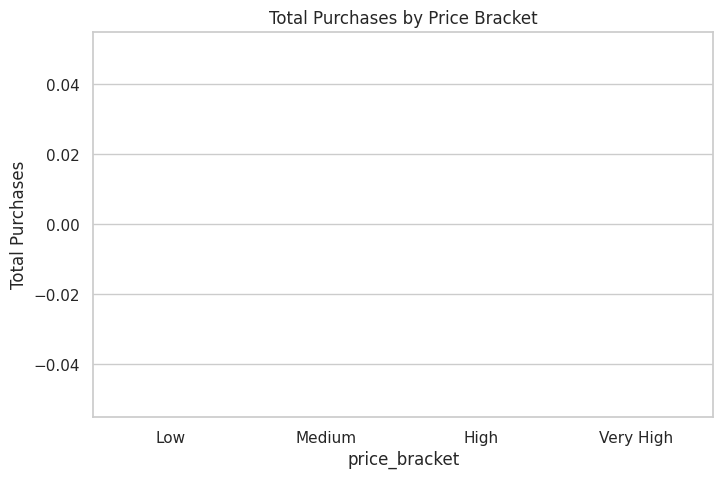

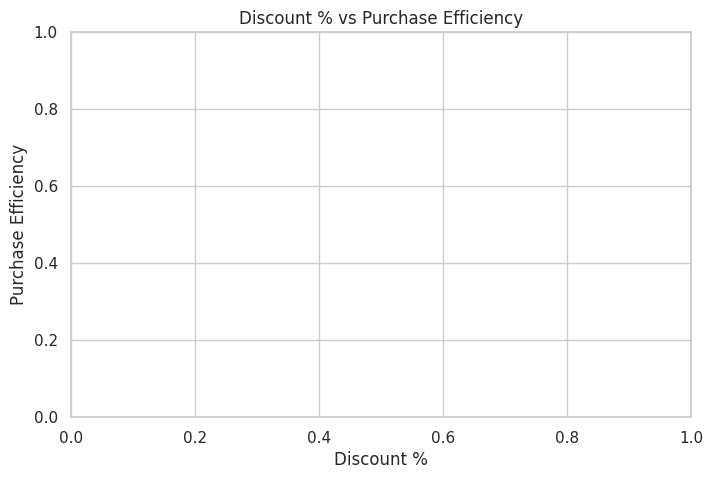

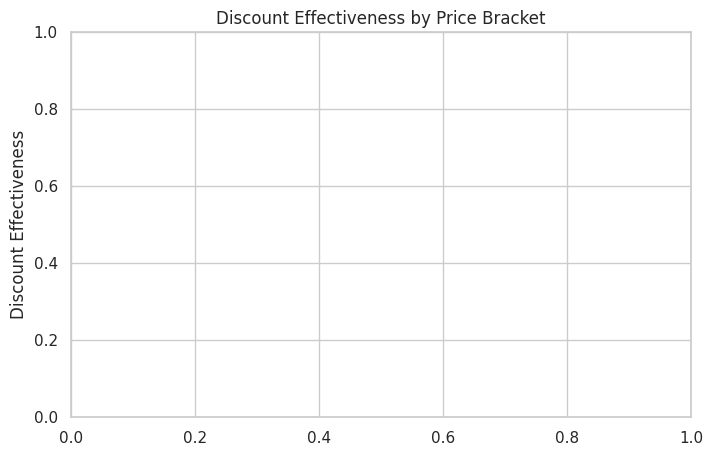


---Key Visuals for Metrics---



In [14]:
summary, segment, popularity = eda_df(grouped_df)

### Legacy

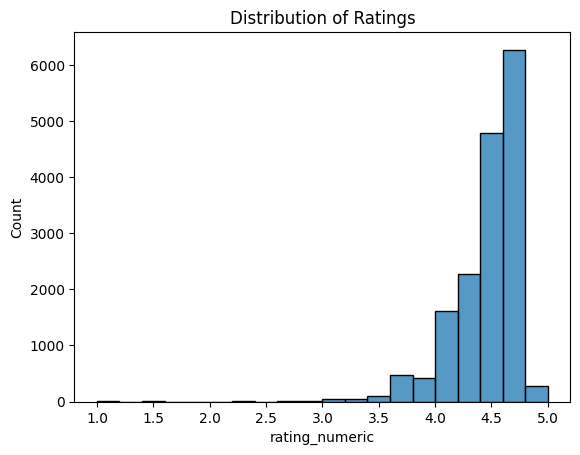

In [12]:
# sns.histplot(df['rating_numeric'].dropna(), bins=20)
# plt.title('Distribution of Ratings')
# plt.show()

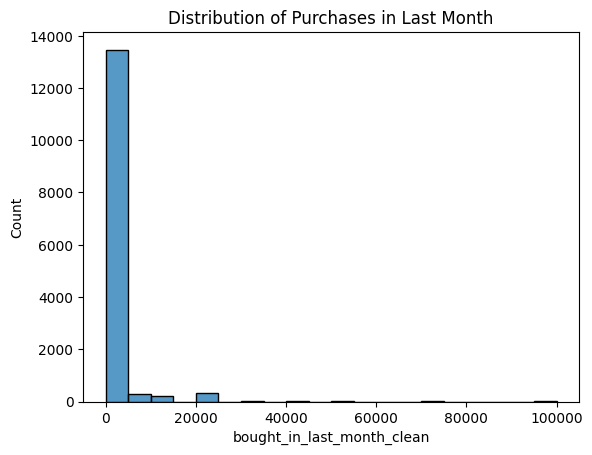

In [13]:
# sns.histplot(df['bought_in_last_month_clean'].dropna(), bins=20)
# plt.title('Distribution of Purchases in Last Month')
# plt.show()

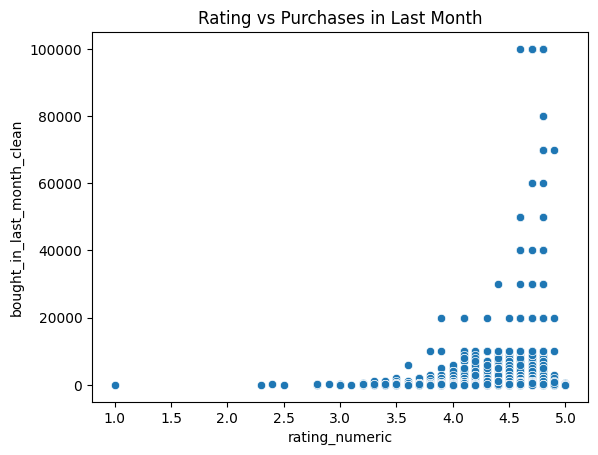

In [14]:
# sns.scatterplot(
#     data=df,
#     x='rating_numeric',
#     y='bought_in_last_month_clean'
# )
# plt.title('Rating vs Purchases in Last Month')
# plt.show()

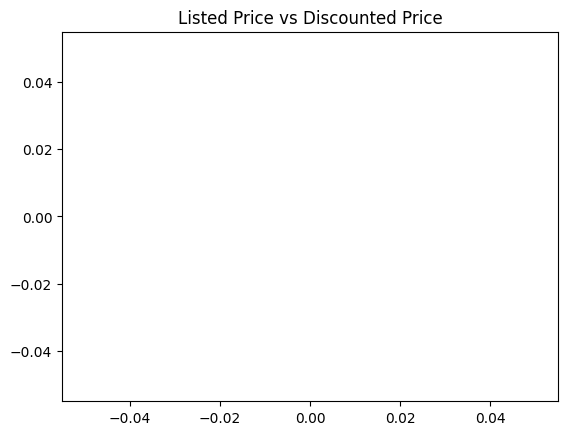

In [15]:
# # Scatter plot: listed price vs discounted price
# sns.scatterplot(
#     data=df,
#     x='listed_price_clean',
#     y='current/discounted_price'
# )
# plt.title('Listed Price vs Discounted Price')
# plt.show()

,bought_in_last_month_clean
sustainability_badges,
1 sustainability certification,80000.000000
Safer chemicals +1 more,44950.000000
Forestry practices,5544.444444
Recycled materials,2633.333333
Carbon impact,2285.786802
Manufacturing practices,2258.108108
Works with Alexa,1573.152709
Recycled materials +3 more,1375.000000
,1276.658655


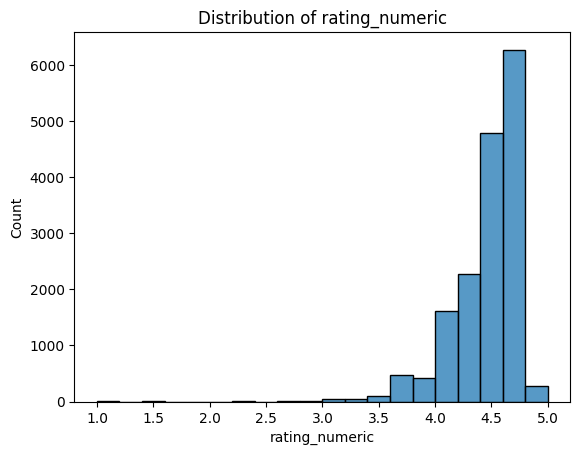

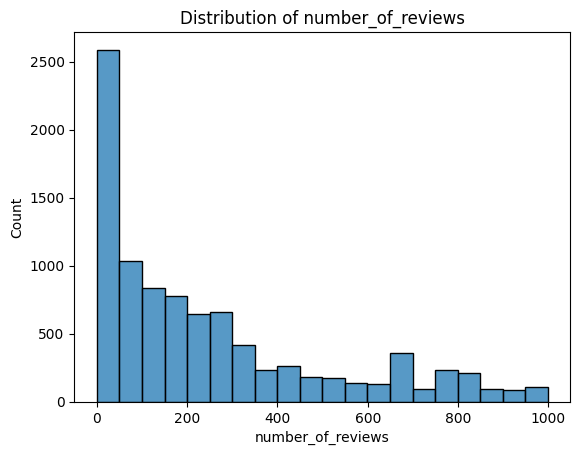

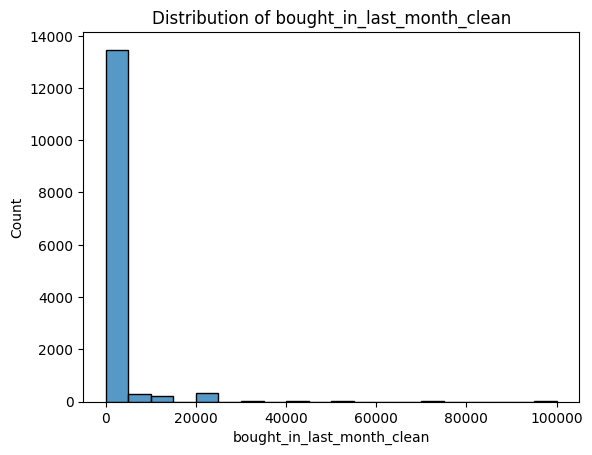

In [17]:
# for col in ['rating_numeric', 'number_of_reviews', 'bought_in_last_month_clean']:
#     sns.histplot(df[col].dropna(), bins=20)
#     plt.title(f'Distribution of {col}')
#     plt.show()

## EDA on Derivied Metrics

In [18]:
#Absolute Discount
sns.histplot(df['discount_amount'].dropna(), bins=30)
plt.title('Distribution of Discount Amount')
plt.xlabel('Discount Amount ($)')
plt.show()

KeyError: 'discount_amount'

In [ ]:
# Discount percentage
sns.histplot(df[df['discount_amount'] > 0]['discount_amount'], bins=30)
plt.yscale('log')
plt.title('Distribution of Discount Amount (Non-zero)')
plt.show()

In [ ]:
# Products per price bracket
sns.countplot(x='price_bracket', data=df)
plt.title('Number of Products per Price Bracket')
plt.show()

In [ ]:
#Average Purchases by price bracket
sns.barplot(x='price_bracket', y='bought_in_last_month_clean', data=df)
plt.title('Average Purchases by Price Bracket')
plt.show()

In [ ]:
#popularity metrics
sns.countplot(x='is_popular', data=df)
plt.title('Number of Popular vs Less Popular Products')
plt.show()

In [ ]:
sns.histplot(df[df['bought_in_last_month_clean']>0]['bought_in_last_month_clean'], bins=30)
plt.xscale('log')
plt.title('Purchases in Last Month (Log Scale)')
plt.show()

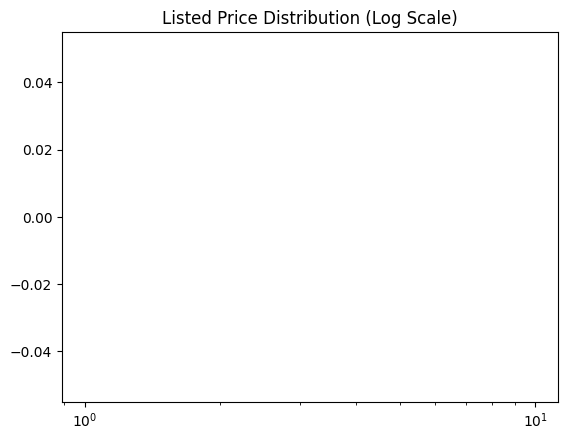

In [19]:
sns.histplot(df[df['listed_price_clean']>0]['listed_price_clean'], bins=30)
plt.xscale('log')
plt.title('Listed Price Distribution (Log Scale)')
plt.show()

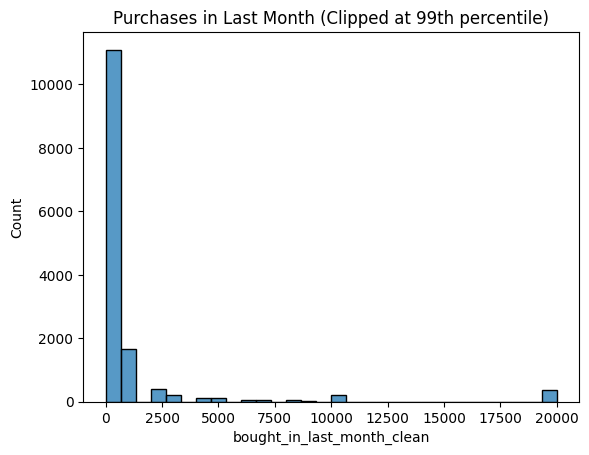

In [20]:
p99 = df['bought_in_last_month_clean'].quantile(0.99)
sns.histplot(df['bought_in_last_month_clean'].clip(upper=p99), bins=30)
plt.title('Purchases in Last Month (Clipped at 99th percentile)')
plt.show()

# Modeling

## Data Prep

In [40]:
# data prep
features = [
    'rating_numeric', 'number_of_reviews', 'bought_in_last_month_clean',
    'listed_price_clean', 'price_on_variant_clean', 'current/discounted_price',
    'discount_amount', 'discount_percentage', 'purchase_efficiency'
]
X = df[features]
y = df['bought_in_last_month_clean']

In [41]:
X = X.fillna(0)
y = y.fillna(0)
y_log = np.log1p(y)

In [42]:
df['purchase_efficiency'].fillna(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

/tmp/ipython-input-1906501822.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['purchase_efficiency'].fillna(0, inplace=True)


## Train/Test Split

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [44]:
print(np.isinf(X).sum())

rating_numeric                 0
number_of_reviews              0
bought_in_last_month_clean     0
listed_price_clean             0
price_on_variant_clean         0
current/discounted_price       0
discount_amount                0
discount_percentage            0
purchase_efficiency           18
dtype: int64


In [45]:
print((X.abs() > 1e10).sum())

rating_numeric                 0
number_of_reviews              0
bought_in_last_month_clean     0
listed_price_clean             0
price_on_variant_clean         0
current/discounted_price       0
discount_amount                0
discount_percentage            0
purchase_efficiency           18
dtype: int64


## Linerar Regression

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred))) # model performance
print("R2 Score:", r2_score(y_test, y_pred))

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients
feature_importance = pd.Series(model.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
print(feature_importance)

In [ ]:
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.xlabel('Actual Purchases')
plt.ylabel('Predicted Purchases')
plt.title('Predicted vs Actual Purchases')
plt.show()

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(importances)

#Business Insights
